In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

In [2]:
df = pd.read_csv(r'/content/AXISBANK.csv')
print(df.head())
print(df.info())

         Date   Symbol Series  Prev Close  Open   High    Low  Last  Close  \
0  2000-01-03  UTIBANK     EQ       24.70  26.7  26.70  26.70  26.7  26.70   
1  2000-01-04  UTIBANK     EQ       26.70  27.0  28.70  26.50  27.0  26.85   
2  2000-01-05  UTIBANK     EQ       26.85  26.0  27.75  25.50  26.4  26.30   
3  2000-01-06  UTIBANK     EQ       26.30  25.8  27.00  25.80  25.9  25.95   
4  2000-01-07  UTIBANK     EQ       25.95  25.0  26.00  24.25  25.0  24.80   

    VWAP  Volume      Turnover  Trades  Deliverable Volume  %Deliverble  
0  26.70  112100  2.993070e+11     NaN                 NaN          NaN  
1  27.24  234500  6.387275e+11     NaN                 NaN          NaN  
2  26.24  170100  4.462980e+11     NaN                 NaN          NaN  
3  26.27  102100  2.681730e+11     NaN                 NaN          NaN  
4  25.04   62600  1.567220e+11     NaN                 NaN          NaN  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5306 entries, 0 to 5305
Data columns 

##Normalizing the Values

In [3]:
data = df['Close'].values
data = data.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)
print(scaled_data[:5])

[[0.00227364]
 [0.00234859]
 [0.00207376]
 [0.00189886]
 [0.00132421]]


###Creating a sequence

In [4]:
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i + seq_length]
        y = data[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 60
X, y = create_sequences(scaled_data, seq_length)

X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

print("X shape:", X.shape)  # (num_samples, seq_length, 1)
print("y shape:", y.shape)  #  (num_samples, 1)



X shape: torch.Size([5246, 60, 1])
y shape: torch.Size([5246, 1])


##Train Test Split

In [5]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Print shapes
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


X_train shape: torch.Size([4196, 60, 1])
X_test shape: torch.Size([1050, 60, 1])
y_train shape: torch.Size([4196, 1])
y_test shape: torch.Size([1050, 1])


### Defining the LSTM model

In [6]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)

        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        out, _ = self.lstm(x, (h0, c0))  # out shape: (batch_size, seq_length, hidden_size)

        out = self.fc(out[:, -1, :])  # out shape: (batch_size, output_size)

        return out

In [7]:
input_size = 1      # Number of features (closing price)
hidden_size = 50    # Number of neurons in the LSTM hidden layer
num_layers = 2      # Number of LSTM layers
output_size = 1     # Number of output features (predicted price)

# Instantiate the model
model = LSTMModel(input_size, hidden_size, num_layers, output_size)

# Print the model architecture
print(model)

LSTMModel(
  (lstm): LSTM(1, 50, num_layers=2, batch_first=True)
  (fc): Linear(in_features=50, out_features=1, bias=True)
)


In [8]:
# Define loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error Loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer

In [9]:
num_epochs = 50
batch_size = 32

train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

for epoch in range(num_epochs):
    model.train()
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [10/50], Loss: 0.0000
Epoch [20/50], Loss: 0.0001
Epoch [30/50], Loss: 0.0001
Epoch [40/50], Loss: 0.0001
Epoch [50/50], Loss: 0.0001


In [10]:
model.eval()

with torch.no_grad():
    X_test = X_test.to(device)

    test_outputs = model(X_test)

    # Inverse transform the predictions and actual values
    test_outputs = scaler.inverse_transform(test_outputs.cpu().numpy())
    y_test_actual = scaler.inverse_transform(y_test.cpu().numpy())

    test_loss = criterion(torch.tensor(test_outputs), torch.tensor(y_test_actual))
    print(f'Test Loss: {test_loss.item():.4f}')

Test Loss: 353.3214


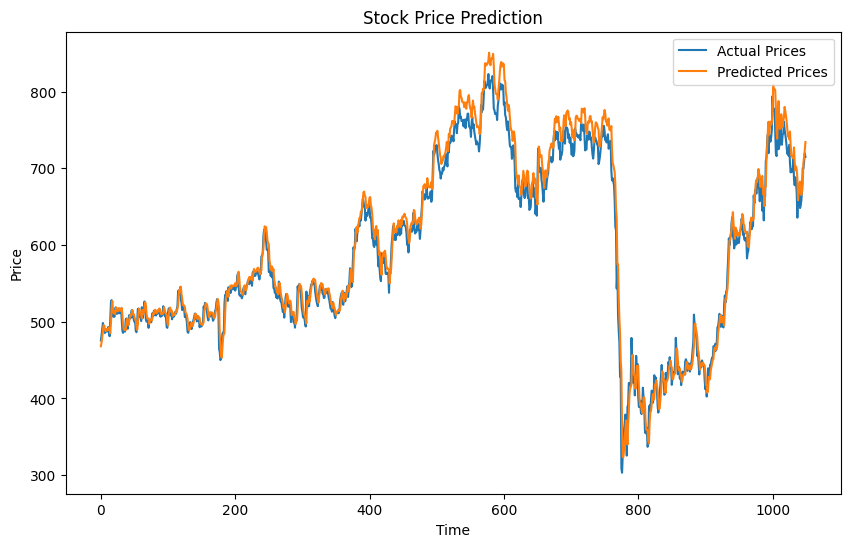

In [11]:
plt.figure(figsize=(10, 6))
plt.plot(y_test_actual, label='Actual Prices')
plt.plot(test_outputs, label='Predicted Prices')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()